# 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

# Data & Library

In [9]:
import os
data_dir = '/content/data'
os.makedirs(data_dir, exist_ok=True)

In [10]:
!wget -O {data_dir}/images.tar "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
!tar -xf {data_dir}/images.tar -C {data_dir}
!rm {data_dir}/images.tar

--2025-11-17 02:04:10--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘/content/data/images.tar’

/content/data/image 100%[===================>] 756.82M  12.7MB/s    in 1m 44s  

2025-11-17 02:05:54 (7.30 MB/s) - ‘/content/data/images.tar’ saved [793579520/793579520]



In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [12]:

DATA_DIR = "data/Images/"
BATCH_SIZE = 64

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda:0


# Augmentation

In [13]:
# 모든 Transform에 공통적으로 적용되는 기본 전처리
def common_transforms(additional_transforms=None):
    transform_list = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
    if additional_transforms:
        transform_list.extend(additional_transforms)


    transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return transforms.Compose(transform_list)


POLICY_MAP = {
    'No Aug': common_transforms(), # A. No Aug (Baseline)

    'Policy 1 (Basic)': common_transforms([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
    ]),

    'Policy 2 (Geometric)': common_transforms([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(
            degrees=20,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2)
        ),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0))
    ]),

    'Policy 3 (Color)': common_transforms([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.6,
            contrast=0.6,
            saturation=0.6,
            hue=0.1
        ),
        transforms.RandomGrayscale(p=0.25),
        transforms.GaussianBlur(kernel_size=3)
    ]),
}

VAL_TRANSFORM = POLICY_MAP['No Aug']

# Dataset

In [19]:

class CustomSubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        return self.transform(img), label
    def __len__(self):
        return len(self.indices)


full_dataset = ImageFolder(root=DATA_DIR, transform=None)
num_classes = len(full_dataset.classes)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

train_indices, val_indices, _ = random_split(
    range(total_size),
    [train_size, val_size, total_size - train_size - val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Number of classes: {num_classes}, Train size: {train_size}")

Number of classes: 120, Train size: 16464


# Model & Train

In [20]:
# 모델 생성 함수
def get_resnet50_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [28]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
import os

criterion = nn.CrossEntropyLoss()

def train(model, train_loader, val_loader, epochs, aug_type, checkpoint_path=None):

    save_dir = 'model'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory '{save_dir}' created for checkpoints.")


    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    model.to(DEVICE)

    start_epoch = 0
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': [], 'epoch_time': []}

    # --------------------- 💡 학습 재개 로직 💡 ---------------------
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        try:
            # map_location='cpu'를 사용하여 GPU 메모리가 부족해도 로드할 수 있게 합니다.
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1 # 다음 에포크부터 시작
            # history 기록도 복원 (원하지 않으면 주석 처리 가능)
            history.update(checkpoint['history'])
            print(f"Training resumed from Epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting training from scratch.")
            start_epoch = 0
   # -------------------- ---------------------


    for epoch in range(start_epoch, epochs):
        start_time = time.time()


        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / total
        train_acc = 100. * correct / total
        history['train_loss'].append(epoch_train_loss)
        history['train_accuracy'].append(train_acc)


        model.eval()
        running_loss_val, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(DEVICE), labels_val.to(DEVICE)
                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, labels_val)
                running_loss_val += loss_val.item() * images_val.size(0)
                _, predicted_val = outputs_val.max(1)
                total_val += labels_val.size(0)
                correct_val += predicted_val.eq(labels_val).sum().item()

        epoch_val_loss = running_loss_val / total_val
        val_acc = 100. * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(val_acc)

        epoch_duration = time.time() - start_time
        history['epoch_time'].append(epoch_duration)

        print(f"Epoch [{epoch+1}/{epochs}] ({aug_type}) | Train Acc: {train_acc:.2f}% |  Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | Time: {epoch_duration:.2f}s")

        # --------------------- 💡 체크포인트 저장 로직 💡 ---------------------
        # 매 에포크마다 현재 상태를 저장 (가장 최신 파일로 덮어쓰기)
        current_checkpoint_path = f'{save_dir}/{aug_type}_checkpoint_latest.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history # history도 포함하여 저장
        }, current_checkpoint_path)
        # ----------------------------------------------------------------------

    return history

In [29]:
EPOCHS = 30

histories = {}
val_subset = CustomSubset(full_dataset, val_indices.indices, transform=VAL_TRANSFORM)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [30]:
for policy_name, policy_transform in POLICY_MAP.items():
    if policy_name == 'No Aug':
        continue

    print(f"\n--- Training: {policy_name} ---")


    train_subset = CustomSubset(full_dataset, train_indices.indices, transform=policy_transform)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

    model = get_resnet50_model(num_classes)

    checkpoint_file = f'model/{policy_name}_checkpoint_latest.pth'

    histories[policy_name] = train(
        model,
        train_loader,
        val_loader,
        EPOCHS,
        aug_type=policy_name,
        checkpoint_path=checkpoint_file
    )


--- Training: Policy 1 (Basic) ---
Epoch [1/30] (Policy 1 (Basic)) | Train Acc: 44.70% |  Train Loss: 3.2501 | Val Acc: 72.84% | Val Loss: 1.6455 | Time: 169.79s
Epoch [2/30] (Policy 1 (Basic)) | Train Acc: 78.48% |  Train Loss: 1.2355 | Val Acc: 79.79% | Val Loss: 0.8671 | Time: 169.70s
Epoch [3/30] (Policy 1 (Basic)) | Train Acc: 83.09% |  Train Loss: 0.7790 | Val Acc: 82.65% | Val Loss: 0.6927 | Time: 168.50s
Epoch [4/30] (Policy 1 (Basic)) | Train Acc: 85.58% |  Train Loss: 0.6107 | Val Acc: 83.53% | Val Loss: 0.6191 | Time: 168.13s
Epoch [5/30] (Policy 1 (Basic)) | Train Acc: 87.54% |  Train Loss: 0.5021 | Val Acc: 82.94% | Val Loss: 0.5849 | Time: 169.82s
Epoch [6/30] (Policy 1 (Basic)) | Train Acc: 89.24% |  Train Loss: 0.4299 | Val Acc: 83.82% | Val Loss: 0.5503 | Time: 169.37s
Epoch [7/30] (Policy 1 (Basic)) | Train Acc: 90.39% |  Train Loss: 0.3792 | Val Acc: 83.62% | Val Loss: 0.5372 | Time: 168.48s
Epoch [8/30] (Policy 1 (Basic)) | Train Acc: 91.76% |  Train Loss: 0.3271 |

# Visualization

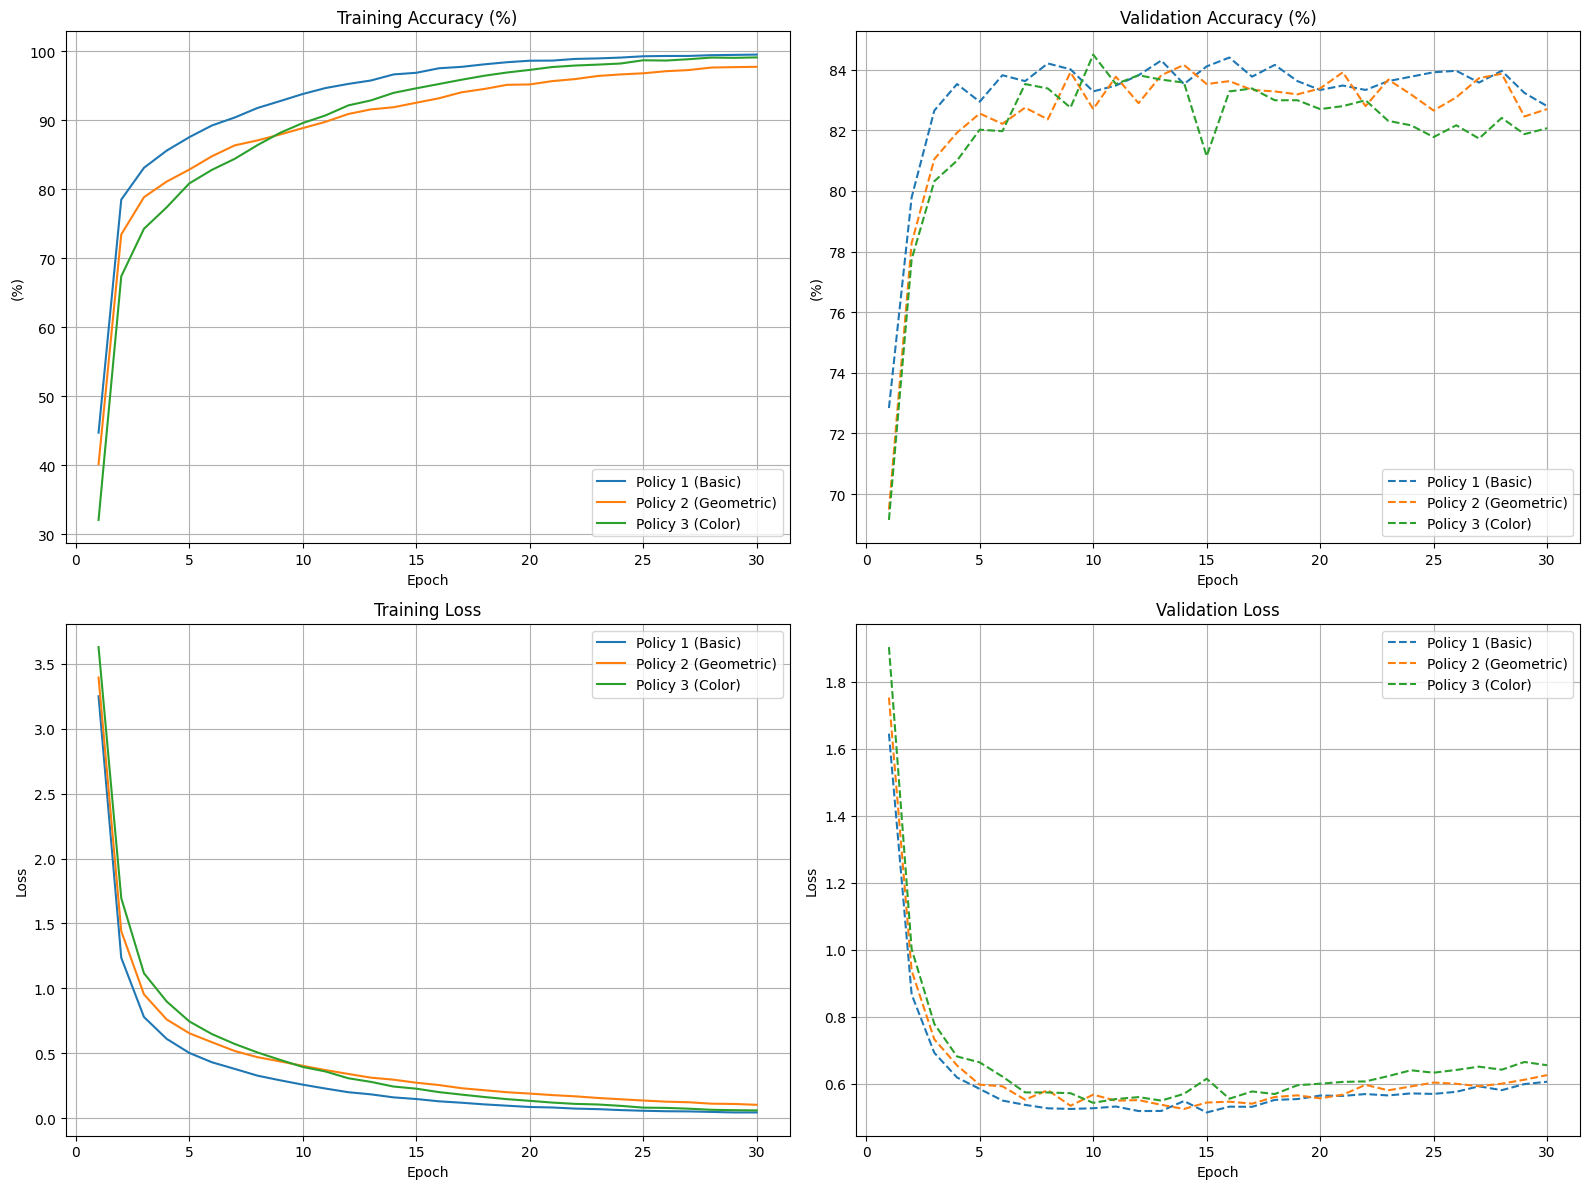

In [31]:
def plot_history_4policies(histories, epochs):
    history_list = list(histories.values())
    labels = list(histories.keys())
    epoch_range = range(1, epochs + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 지표 및 위치 정의
    metrics = [('train_accuracy', 'Training Accuracy (%)', 0, 0),
               ('train_loss', 'Training Loss', 1, 0),
               ('val_accuracy', 'Validation Accuracy (%)', 0, 1),
               ('val_loss', 'Validation Loss', 1, 1)]

    for metric_key, title, row, col in metrics:
        ax = axes[row, col]
        style = '-' if 'train' in metric_key else '--'
        loc = 'lower right' if 'accuracy' in metric_key else 'upper right'

        for hist, label in zip(history_list, labels):
            ax.plot(epoch_range, hist[metric_key], label=label, linestyle=style)

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title.split(' ')[-1])
        ax.legend(loc=loc)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# 함수 실행
plot_history_4policies(histories, EPOCHS)

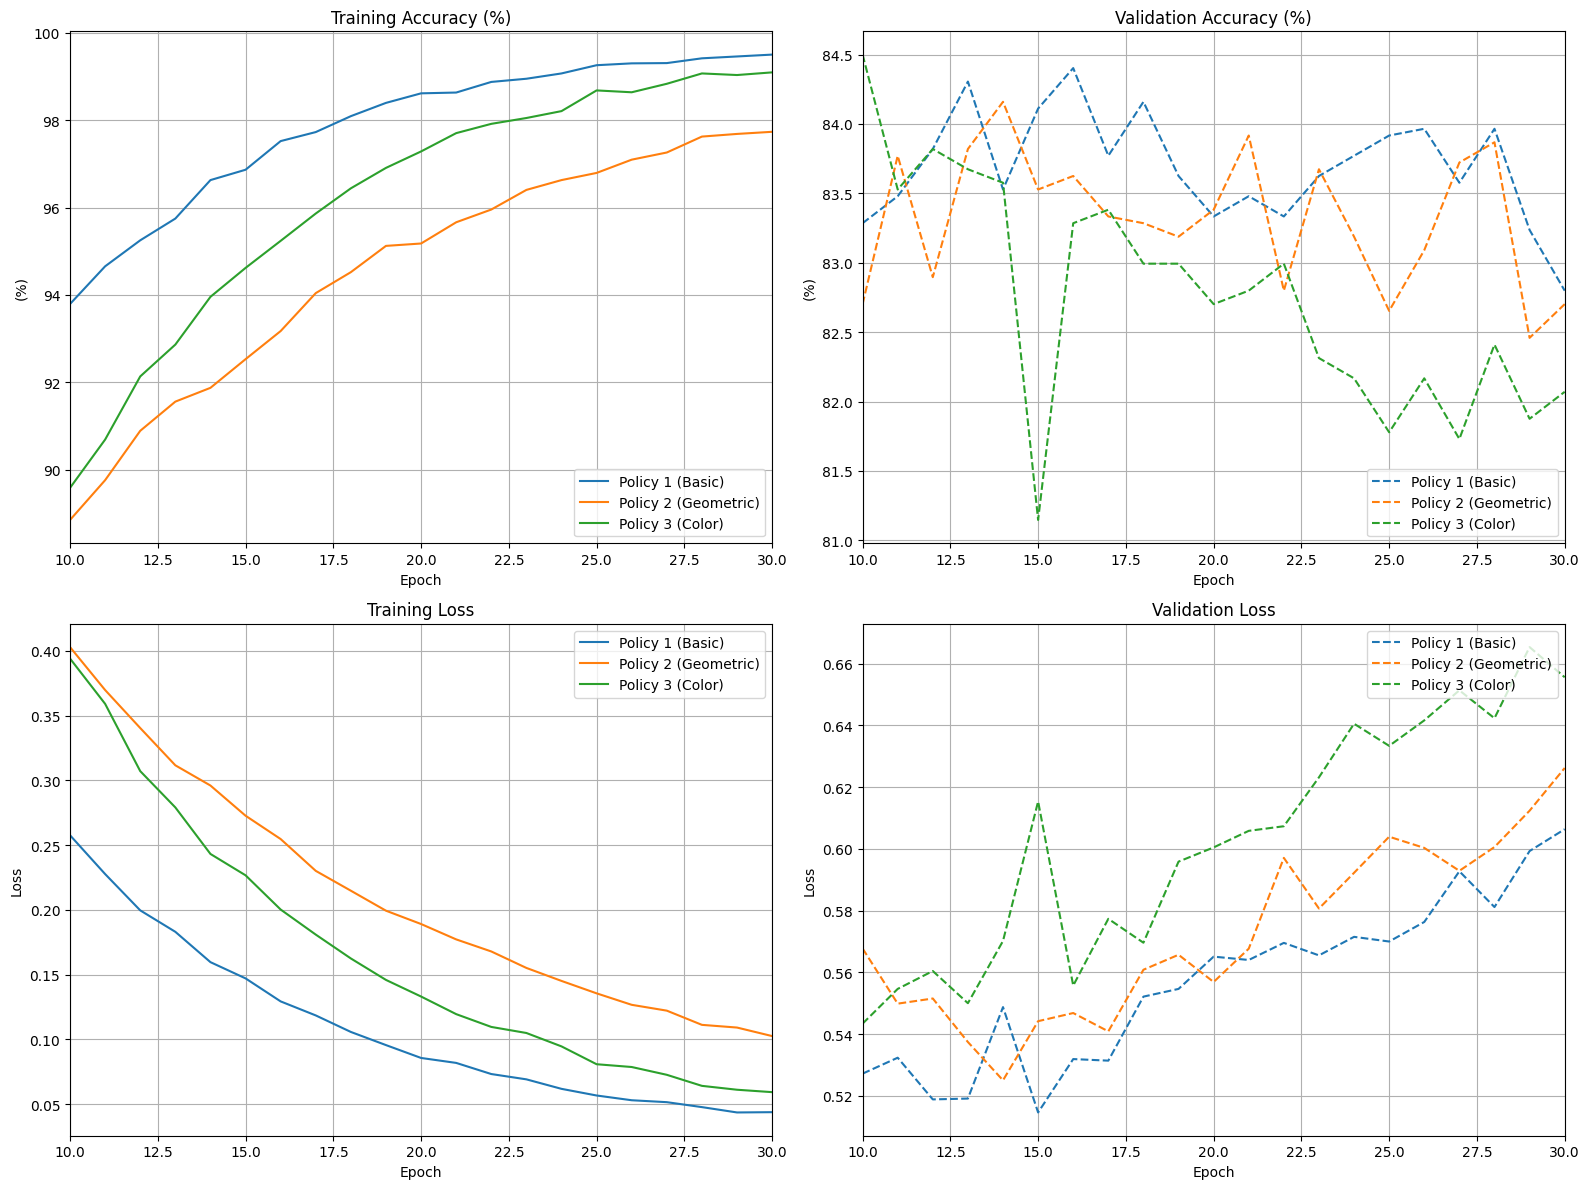

In [33]:
def plot_history_4policies_zoomed(histories, epochs, start_epoch=4):
    """
    훈련 이력(histories)을 기반으로 4개의 지표(Train/Val Accuracy, Train/Val Loss)를
    start_epoch 이후부터 시각화하는 함수.

    :param histories: 각 정책별 훈련 이력을 담고 있는 딕셔너리.
    :param epochs: 총 에포크 수.
    :param start_epoch: 시각화를 시작할 에포크 번호 (기본값 4).
    """
    # 0. 슬라이싱 시작 인덱스 계산 (Epoch 1이 인덱스 0이므로, start_epoch는 인덱스 start_epoch - 1에 해당)
    # Epoch 4부터 시작하려면 인덱스 3 (4 - 1)부터 시작해야 합니다.
    start_index = start_epoch - 1

    # 1. epoch_range를 start_epoch부터 epochs까지로 재정의
    # start_epoch가 1부터 시작하는 실제 epoch 번호이므로, range(start_epoch, epochs + 1)
    epoch_range_zoomed = range(start_epoch, epochs + 1)

    history_list = list(histories.values())
    labels = list(histories.keys())

    # 총 에포크 수에 start_epoch까지의 에포크가 포함되지 않는지 확인
    if start_epoch > epochs:
        print(f"오류: 시작 에포크({start_epoch})가 총 에포크 수({epochs})보다 큽니다.")
        return

    # 그래프 레이아웃 설정
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 지표 및 위치 정의
    metrics = [('train_accuracy', 'Training Accuracy (%)', 0, 0),
               ('train_loss', 'Training Loss', 1, 0),
               ('val_accuracy', 'Validation Accuracy (%)', 0, 1),
               ('val_loss', 'Validation Loss', 1, 1)]

    for metric_key, title, row, col in metrics:
        ax = axes[row, col]
        style = '-' if 'train' in metric_key else '--'
        loc = 'lower right' if 'accuracy' in metric_key else 'upper right'

        for hist, label in zip(history_list, labels):
            # 2. metric 데이터 리스트를 start_index부터 끝까지 슬라이싱
            # hist[metric_key]는 0부터 시작하는 인덱스를 가지므로 [start_index:]를 사용합니다.
            zoomed_data = hist[metric_key][start_index:]

            # 슬라이싱된 데이터와 새로운 epoch_range_zoomed를 사용하여 플롯
            ax.plot(epoch_range_zoomed, zoomed_data, label=label, linestyle=style)

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        # Y축 라벨은 변경하지 않고 기존 함수처럼 유지
        ax.set_ylabel(title.split(' ')[-1])
        ax.legend(loc=loc)
        # X축 범위를 start_epoch부터 epochs까지 명시적으로 설정
        ax.set_xlim(start_epoch, epochs)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# 함수 실행 예시 (실제 실행을 위해서는 histories 딕셔너리와 EPOCHS 변수가 정의되어야 합니다.)
plot_history_4policies_zoomed(histories, EPOCHS, start_epoch=10)